##### Machine Learning Nanodegree
##### Capstone Project: Electric Vehicle Detection 
##### Salvador Nunez

# Setup

In [81]:
# Import libraries necessary for this project
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Import functions defined for this project, located in this repo in ev_capstone_lib.py
import ev_capstone_lib as ev

# Pretty display for notebooks
%matplotlib inline

# Data Exploration

## Import

In [2]:
ev_train_raw = pd.read_csv('EV_train.csv')
ev_train_labels_raw = pd.read_csv('EV_train_labels.csv')

## Inspect

In [3]:
print(ev_train_raw.shape)
print(ev_train_labels_raw.shape)

(1590, 2881)
(1590, 2881)


In [4]:
display(ev_train_raw.head())
display(ev_train_labels_raw.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0.950,0.826,0.361,0.238,0.342,0.233000,0.351000,0.194000,0.292000,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
1,11633257,0.353,0.327,0.358,0.292,0.285,0.304000,0.361000,0.342000,0.355000,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
2,11651552,0.150,0.181,0.150,0.150,0.131,0.125000,0.088000,0.106000,0.094000,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113
3,11636092,2.088,2.075,2.121,2.098,2.046,2.081000,1.847000,0.420000,0.399000,...,0.620,0.487,0.563,0.419,0.379,0.359,0.347,0.325,0.330,0.340
4,11647239,1.416,1.250,1.270,1.258,1.239,1.753105,4.609256,4.619256,4.075151,...,1.596,1.667,1.569,1.664,1.580,1.635,1.568,1.565,1.575,1.571


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11655099,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11633257,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11651552,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11636092,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11647239,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


## Quantify Class Imbalance

In [5]:
# % EV Houses
ev_houses_raw = sum(ev_train_labels_raw.drop('House ID', axis=1).sum(axis=1) > 0)
print("{} houses have EVs, representing {:.0%} of all houses.".format(
    ev_houses_raw, ev_houses_raw/ev_train_labels_raw.shape[0]
))

485 houses have EVs, representing 31% of all houses.


In [6]:
# % EV Intervals Total
ev_intervals_raw = ev_train_labels_raw.drop('House ID', axis=1).values.sum()
print("{} intervals have charging EVs, representing {:.0%} of all intervals for all houses.".format(
    ev_intervals_raw, ev_intervals_raw/(1590*2800)
))

106910 intervals have charging EVs, representing 2% of all intervals for all houses.


In [7]:
print("{} intervals have charging EVs, representing {:.0%} of all intervals for all EV houses.".format(
    ev_intervals_raw, ev_intervals_raw/(485*2800)
))

106910 intervals have charging EVs, representing 8% of all intervals for all EV houses.


## Quantify Missing Values

In [8]:
print(ev_train_raw.isnull().values.any())  # Null values in training dataset?
print(ev_train_labels_raw.isnull().values.any())  #Null values in training labels?

True
False


In [9]:
# Count Nulls
ev_train_raw.isnull().sum().sum()

720

In [10]:
# Count Nulls by House
print(ev_train_raw['House ID'][ev_train_raw.isnull().sum(axis=1)>0])
print(ev_train_raw.isnull().sum(axis=1)[ev_train_raw.isnull().sum(axis=1)>0])

290     11637447
539     11635802
1159    11637232
1374    11632700
Name: House ID, dtype: int64
290      96
539      48
1159    432
1374    144
dtype: int64


In [11]:
# Show records with missing values
ev_train_raw[ev_train_raw.isnull().any(axis=1)]

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
290,11637447,2.395,2.380,2.336,2.417,2.422,2.497,2.486,3.015,2.317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539,11635802,0.249,0.271,0.266,0.255,0.247,0.280,0.178,0.237,0.133,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1159,11637232,1.218,1.087,0.995,0.791,0.798,0.756,0.745,0.736,0.699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1374,11632700,0.113,0.106,0.113,0.150,0.119,0.106,0.100,0.144,0.144,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Visualizations

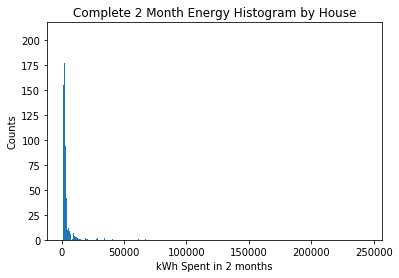

In [12]:
house_totals = ev_train_raw.drop(['House ID'], axis=1).sum(axis=1)
plt.hist(house_totals, bins='auto') 
plt.xlabel('kWh Spent in 2 months')
plt.ylabel('Counts')
plt.title("Complete 2 Month Energy Histogram by House")
plt.show()

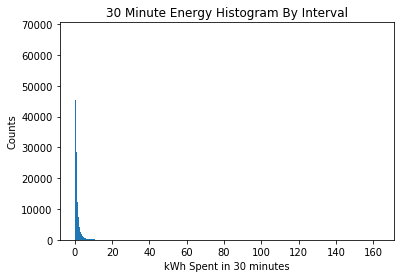

In [13]:
interval_values = ev_train_raw.drop(['House ID'], axis=1).values.flatten()
interval_values = interval_values[~np.isnan(interval_values)]
plt.hist(interval_values, bins='auto') 
plt.xlabel('kWh Spent in 30 minutes')
plt.ylabel('Counts')
plt.title("30 Minute Energy Histogram By Interval")
plt.show()

# Data Preprocessing

## Pivot and Combine

In [14]:
ev_train_kwh_pivot = ev.pivot_raw_df(ev_train_raw, 'kWh')
display(ev_train_kwh_pivot.head())

,House ID,Interval,kWh
0,11628280,1,1.114
1,11628280,2,0.845
2,11628280,3,0.463
3,11628280,4,0.453
4,11628280,5,0.610


In [15]:
ev_train_labels_pivot = ev.pivot_raw_df(ev_train_labels_raw, 'Label')
display(ev_train_labels_pivot.head())

,House ID,Interval,Label
0,11628280,1,0
1,11628280,2,0
2,11628280,3,0
3,11628280,4,0
4,11628280,5,0


In [16]:
ev_train_piv_w_lab = pd.concat([ev_train_kwh_pivot, ev_train_labels_pivot['Label']], axis=1)
display(ev_train_piv_w_lab.head())

,House ID,Interval,kWh,Label
0,11628280,1,1.114,0
1,11628280,2,0.845,0
2,11628280,3,0.463,0
3,11628280,4,0.453,0
4,11628280,5,0.610,0


## Add Temporal Dimensions

In [17]:
ev_train_piv_lab_tmp = ev.add_temp_dim(ev_train_piv_w_lab)
display(ev_train_piv_lab_tmp.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Label
0,11628280,1,1,1,1,1.114,0
1,11628280,1,1,2,2,0.845,0
2,11628280,1,2,3,3,0.463,0
3,11628280,1,2,4,4,0.453,0
4,11628280,1,3,5,5,0.610,0


## Fill in Missing Values

In [18]:
ev_train_piv_lab_tmp_filled = ev.fill_with_mean(ev_train_piv_lab_tmp)
display(ev_train_piv_lab_tmp_filled.head())

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_filled['kWh'][house_rf&interval_rf] = house_half_hour_average


,House ID,Day,Hour,Half Hour,Interval,kWh,Label
0,11628280,1,1,1,1,1.114,0
1,11628280,1,1,2,2,0.845,0
2,11628280,1,2,3,3,0.463,0
3,11628280,1,2,4,4,0.453,0
4,11628280,1,3,5,5,0.610,0


# House Classification

## Training and Validation Split

In [19]:
X_house, y_house = ev.house_agg_and_split(ev_train_piv_lab_tmp_filled)

In [20]:
X_house.columns.values

array(['House ID', 'u_1', 'u_2', 'u_3', 'u_4', 'u_5', 'u_6', 'u_7', 'u_8',
       'u_9', 'u_10', 'u_11', 'u_12', 'u_13', 'u_14', 'u_15', 'u_16',
       'u_17', 'u_18', 'u_19', 'u_20', 'u_21', 'u_22', 'u_23', 'u_24',
       'u_25', 'u_26', 'u_27', 'u_28', 'u_29', 'u_30', 'u_31', 'u_32',
       'u_33', 'u_34', 'u_35', 'u_36', 'u_37', 'u_38', 'u_39', 'u_40',
       'u_41', 'u_42', 'u_43', 'u_44', 'u_45', 'u_46', 'u_47', 'u_48',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9',
       's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17',
       's_18', 's_19', 's_20', 's_21', 's_22', 's_23', 's_24', 's_25',
       's_26', 's_27', 's_28', 's_29', 's_30', 's_31', 's_32', 's_33',
       's_34', 's_35', 's_36', 's_37', 's_38', 's_39', 's_40', 's_41',
       's_42', 's_43', 's_44', 's_45', 's_46', 's_47', 's_48', 'p_1',
       'p_2', 'p_3', 'p_4', 'p_5', 'p_6', 'p_7', 'p_8', 'p_9', 'p_10',
       'p_11', 'p_12', 'p_13', 'p_14', 'p_15', 'p_16', 'p_17', 'p_18',
     

In [21]:
display(X_house.head())
display(y_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_39,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48
0,11628280,1.034950,0.990733,0.904383,0.940583,0.958350,0.940750,0.936317,0.919983,0.894133,...,0.021406,0.020981,0.019509,0.019009,0.019226,0.018909,0.019017,0.019521,0.019504,0.019241
1,11628291,0.742283,0.743917,0.742250,0.740300,0.743651,0.838403,0.771068,0.797265,0.762628,...,0.020703,0.018956,0.018786,0.018658,0.017564,0.017195,0.017451,0.018865,0.018214,0.017874
2,11628301,0.236132,0.273704,0.255804,0.248360,0.191183,0.202845,0.314648,0.314576,0.251421,...,0.063615,0.060917,0.055962,0.040179,0.025159,0.013686,0.010051,0.006760,0.006476,0.005591
3,11628319,0.779583,0.766733,0.660650,0.591733,0.600967,0.578200,0.581083,0.595033,0.615067,...,0.030123,0.035465,0.036182,0.035222,0.032022,0.030527,0.027833,0.024870,0.019554,0.017096
4,11628335,0.299017,0.301467,0.297050,0.286950,0.283717,0.293583,0.790850,0.914083,0.929167,...,0.037180,0.037238,0.021009,0.016897,0.015468,0.012938,0.011480,0.009744,0.008606,0.008468


0    0
1    1
2    1
3    0
4    0
Name: House Label, dtype: int64

In [22]:
X_train_house, X_valid_house, y_train_house, y_valid_house = train_test_split(X_house,
                                                                            y_house,
                                                                            test_size=0.25,
                                                                            random_state=42)

## Augment Data

## Perform K-Means Clustering

In [23]:
Image(url= "http://aprs.org/Energy/Charging/L1-EV-timed-charging.GIF")

Best clustering was when k = 9, with a ratio of 5.069


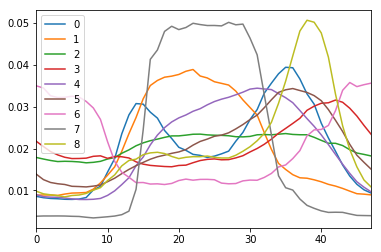

In [24]:
X_train_house, centers_df, k_col_name = ev.cluster_retrieve_best_k(X_train_house, y_train_house)

Ratio defined as the maximum percent / minimum percent, where percent is the percent of positively identified EV houses in each of the k clusters. This helps descriminate ev houses depending on what cluster it belongs to.

In [25]:
display(X_train_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48,k_9
602,11638880,0.305867,0.289133,0.275450,0.261250,0.259183,0.291583,0.532667,0.642067,0.711217,...,0.035223,0.033186,0.030959,0.029389,0.027297,0.016718,0.012797,0.012377,0.011757,5
483,11636498,0.389817,0.371250,0.367267,0.368383,0.366217,0.365183,0.356867,0.359200,0.360800,...,0.021319,0.021060,0.021830,0.020230,0.019202,0.015799,0.013511,0.011439,0.010201,0
1286,11650343,0.237557,0.192169,0.234931,0.247390,0.181961,0.158980,0.188654,0.261955,0.222893,...,0.051914,0.053570,0.045476,0.019140,0.014406,0.011500,0.010308,0.008121,0.006240,8
1009,11645819,0.714400,0.696000,0.684533,0.673533,0.646900,0.635050,0.632483,0.598383,0.595467,...,0.023128,0.025465,0.026261,0.030501,0.032329,0.027500,0.027435,0.029378,0.029757,3
411,11635443,0.316750,0.300883,0.301883,0.294950,0.295750,0.298600,0.290733,0.284767,0.276817,...,0.053381,0.053078,0.046755,0.038444,0.024479,0.015984,0.010947,0.008577,0.007237,8


## Train Model

In [26]:
h_clf1 = GradientBoostingClassifier(random_state = 42)
h_clf1.fit(X_train_house, y_train_house)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [27]:
y_train_house_pred = h_clf1.predict(X_train_house)

### F1 Benchmark

In [28]:
ev.show_baseline_f1_scores(y_train_house)

All 0 F-score: 0.000
Alternating 0,1 F-score: 0.386
All 1 F-score: 0.461


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
f1_score(y_train_house, y_train_house_pred)

0.98145506419400852

In [30]:
confusion_matrix(y_train_house, y_train_house_pred)

array([[835,   0],
       [ 13, 344]])

## Validate Model

In [31]:
KNN_cols = ['p_{}'.format(n) for n in np.arange(1,49)]

In [32]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_house[KNN_cols], X_train_house[k_col_name]) 
X_valid_house[k_col_name] = neigh.predict(X_valid_house[KNN_cols])

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The validation data did not go through k-means clustering. Instead, the cluster is predicted on the validation dataset using k-nearest neighbors (KNN). Where the KNN model was trained exclusively on the training dataset.

In [33]:
y_valid_house_pred = h_clf1.predict(X_valid_house)

### F1 Benchmark

In [34]:
ev.show_baseline_f1_scores(y_valid_house)

All 0 F-score: 0.000
Alternating 0,1 F-score: 0.367
All 1 F-score: 0.487


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
f1_score(y_valid_house, y_valid_house_pred)

0.75303643724696356

In [36]:
confusion_matrix(y_valid_house, y_valid_house_pred)

array([[244,  26],
       [ 35,  93]])

# Time Classification

## Training and Validation Split

In [37]:
X_train_time, y_train_time = ev.transform_house_subset_to_time(
    X_train_house,
    y_train_house,
    ev_train_piv_lab_tmp_filled
)

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t_X.drop(['Label'], axis=1, inplace=True)


In [38]:
display(X_train_time.head())
display(y_train_time.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
2880,11628291,1,1,1,1,0.728
2881,11628291,1,1,2,2,0.742
2882,11628291,1,2,3,3,0.749
2883,11628291,1,2,4,4,0.749
2884,11628291,1,3,5,5,0.743


2880    0
2881    0
2882    0
2883    0
2884    0
Name: Label, dtype: int64

In [39]:
X_valid_time, y_valid_time = ev.transform_house_subset_to_time(
    X_valid_house,
    y_valid_house_pred, # use predicted values, not true values
    ev_train_piv_lab_tmp_filled
)

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t_X.drop(['Label'], axis=1, inplace=True)


In [40]:
display(X_valid_time.head())
display(y_valid_time.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
66240,11628565,1,1,1,1,0.341
66241,11628565,1,1,2,2,0.324
66242,11628565,1,2,3,3,0.292
66243,11628565,1,2,4,4,0.161
66244,11628565,1,3,5,5,0.127


66240    0
66241    0
66242    0
66243    0
66244    0
Name: Label, dtype: int64

## Augment Data

### Difference between Clusters and Intervals

In [41]:
X_train_time_augmented = ev.augment_time_data(
    X_train_time, 
    X_train_house, 
    centers_df)
display(X_train_time_augmented.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Day_kWh,k_9,c1,c2,...,c7,c8,c9,1d_diff,2d_diff,3d_diff,4d_diff,5d_diff,6d_diff,7d_diff
0,11628291,1,1,1,1,0.728,46.874768,2,0.402390,0.415635,...,1.638111,0.180460,0.459661,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11628291,1,1,2,2,0.742,46.874768,2,0.387550,0.418082,...,1.613683,0.183183,0.430759,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11628291,1,2,3,3,0.749,46.874768,2,0.379119,0.417758,...,1.526961,0.183104,0.420003,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11628291,1,2,4,4,0.749,46.874768,2,0.375727,0.413071,...,1.507586,0.183534,0.410290,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11628291,1,3,5,5,0.743,46.874768,2,0.369906,0.428265,...,1.509910,0.182633,0.396734,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_train_time_augmented.columns.values

array(['House ID', 'Day', 'Hour', 'Half Hour', 'Interval', 'kWh',
       'Day_kWh', 'k_9', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', '1d_diff', '2d_diff', '3d_diff', '4d_diff', '5d_diff',
       '6d_diff', '7d_diff'], dtype=object)

In [43]:
X_valid_time_augmented = ev.augment_time_data(
    X_valid_time, 
    X_valid_house, 
    centers_df) # centers do not reflect validation data
display(X_valid_time_augmented.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Day_kWh,k_9,c1,c2,...,c7,c8,c9,1d_diff,2d_diff,3d_diff,4d_diff,5d_diff,6d_diff,7d_diff
0,11628565,1,1,1,1,0.341,45.329443,0,0.389124,0.401932,...,1.584107,0.174511,0.444507,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11628565,1,1,2,2,0.324,45.329443,0,0.374774,0.404299,...,1.560485,0.177144,0.416558,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11628565,1,2,3,3,0.292,45.329443,0,0.366620,0.403986,...,1.476622,0.177067,0.406157,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11628565,1,2,4,4,0.161,45.329443,0,0.363341,0.399453,...,1.457886,0.177484,0.396764,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11628565,1,3,5,5,0.127,45.329443,0,0.357711,0.414147,...,1.460132,0.176612,0.383655,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train Model

In [44]:
t_clf1 = GradientBoostingClassifier(random_state = 42)
t_clf1.fit(X_train_time_augmented, y_train_time)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [45]:
y_train_time_pred = t_clf1.predict(X_train_time_augmented)

In [46]:
all_y_train_time_pred, all_y_train_time_true, all_Xy_train_time = ev.get_all_relevant_preds_and_trues(
    X_train_time_augmented,
    y_train_time_pred,
    X_train_house,
    ev_train_piv_lab_tmp_filled)
display(all_Xy_train_time.head())

1028160 base predictions extended to 3432960 total predictions, filled with zeros for non-EV houses.


,House ID,Interval,Predicted Label,True Label,Filled Label
0,11638880,1,NaN,0,0
1,11638880,2,NaN,0,0
2,11638880,3,NaN,0,0
3,11638880,4,NaN,0,0
4,11638880,5,NaN,0,0


### F1 Benchmark

In [47]:
ev.show_baseline_f1_scores(all_y_train_time_true)

/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


All 0 F-score: 0.000
Alternating 0,1 F-score: 0.043
All 1 F-score: 0.044


In [48]:
f1_score(all_y_train_time_true, all_y_train_time_pred)

0.72386198145718295

In [49]:
confusion_matrix(all_y_train_time_true, all_y_train_time_pred)

array([[3344456,   10789],
       [  27513,   50202]])

## Validate Model

In [50]:
y_valid_time_pred = t_clf1.predict(X_valid_time_augmented)

In [51]:
all_y_valid_time_pred, all_y_valid_time_true, all_Xy_valid_time = ev.get_all_relevant_preds_and_trues(
    X_valid_time_augmented,
    y_valid_time_pred,
    X_valid_house,
    ev_train_piv_lab_tmp_filled)
display(all_Xy_valid_time.head())

342720 base predictions extended to 1146240 total predictions, filled with zeros for non-EV houses.


,House ID,Interval,Predicted Label,True Label,Filled Label
0,11646896,1,NaN,0,0
1,11646896,2,NaN,0,0
2,11646896,3,NaN,0,0
3,11646896,4,NaN,0,0
4,11646896,5,NaN,0,0


### F1 Benchmark

In [52]:
ev.show_baseline_f1_scores(all_y_valid_time_true)

All 0 F-score: 0.000


/Users/salvadornunez/anaconda/envs/ev-capstone/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Alternating 0,1 F-score: 0.048
All 1 F-score: 0.050


In [53]:
f1_score(all_y_valid_time_true, all_y_valid_time_pred)

0.56518692056626818

In [54]:
confusion_matrix(all_y_valid_time_true, all_y_valid_time_pred)

array([[1110412,    6633],
       [  15082,   14113]])

## Validation Results in Original Format

In [55]:
ev_train_label_predictions = ev.format_ev_predictions(
    all_y_valid_time_pred, 
    all_Xy_valid_time
)
display(ev_train_label_predictions.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11628488,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11628565,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11628652,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11628698,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11628747,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Refinement

In [90]:
# sklearn.model_selection.GridSearchCV¶
# http://scikit-learn.org/stable/modules/grid_search.html
# https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers-python
# https://github.com/torenunez/machine-learning/blob/master/projects/finding_donors/finding_donors.ipynb
    
h_clf1 = GradientBoostingClassifier(random_state = 42)
h_clf2 = SVC(random_state=42)
h_clf3 = MLPClassifier(random_state=42)
h_clf4 = AdaBoostClassifier(random_state = 42)
h_clf5 = RandomForestClassifier(random_state = 42)
h_clf6 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=90, random_state=42)
h_clf7 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=95, random_state=42)

h_classifiers = [h_clf1, h_clf2, h_clf3, h_clf4, h_clf5, h_clf6, h_clf7]
train_h_f1_scores = list()
valid_h_f1_scores = list()

for h_clf in h_classifiers:
    h_clf.fit(X_train_house, y_train_house)
    y_train_house_pred = h_clf.predict(X_train_house)
    train_h_f1_score = f1_score(y_train_house, y_train_house_pred)
    train_h_f1_scores.append(train_h_f1_score)

    y_valid_house_pred = h_clf.predict(X_valid_house)
    valid_h_f1_score = f1_score(y_valid_house, y_valid_house_pred)
    valid_h_f1_scores.append(valid_h_f1_score)

In [91]:
valid_h_f1_scores

[0.75303643724696356,
 0.092105263157894746,
 0.48669201520912547,
 0.65843621399176955,
 0.6785714285714286,
 0.5714285714285714,
 0.70588235294117652]

# Predict Test Data

## Import

In [56]:
ev_test_raw = pd.read_csv('EV_test.csv')

In [57]:
print(ev_test_raw.shape)
display(ev_test_raw.head())

(699, 2881)


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11643173,1.013,0.215,0.217,0.217,0.217,0.220,0.220,0.215,0.215,...,1.059,0.308,1.248,0.236,0.206,0.210,0.218,0.219,0.909,0.202
1,11655020,1.325,1.413,0.813,0.588,0.213,0.175,0.163,0.200,0.175,...,0.750,0.625,0.450,1.325,0.350,0.313,0.188,0.200,0.188,0.175
2,11644367,1.543,1.636,1.683,1.556,1.935,2.393,2.601,2.709,2.590,...,2.208,2.423,2.458,2.487,2.354,2.444,2.430,2.275,1.914,1.497
3,11633356,0.153,0.123,0.146,0.101,0.140,0.108,0.121,0.127,0.110,...,0.216,0.237,0.213,0.258,0.275,0.219,0.218,0.079,0.049,0.055
4,11649905,0.187,0.004,0.004,0.004,0.004,0.004,0.005,0.004,0.004,...,0.004,0.005,0.526,0.005,0.004,0.004,0.004,0.004,0.004,0.004


## Data Preprocessing

In [58]:
print(ev_test_raw.isnull().values.any())
display(ev_test_raw[ev_test_raw.isnull().any(axis=1)])

True


,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
568,11646117,0.797,0.794,0.789,0.786,0.789,0.79,0.787,0.789,0.788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,11643165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.028,1.416,0.973,0.956,0.952,1.101,1.044,1.066,1.314,1.051


In [59]:
ev_test_kwh_pivot = ev.pivot_raw_df(ev_test_raw, 'kWh')
display(ev_test_kwh_pivot.head())

,House ID,Interval,kWh
0,11628297,1,0.815
1,11628297,2,0.743
2,11628297,3,0.832
3,11628297,4,0.880
4,11628297,5,0.909


In [60]:
ev_test_kwh_tmp = ev.add_temp_dim(ev_test_kwh_pivot)
display(ev_test_kwh_tmp.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
0,11628297,1,1,1,1,0.815
1,11628297,1,1,2,2,0.743
2,11628297,1,2,3,3,0.832
3,11628297,1,2,4,4,0.880
4,11628297,1,3,5,5,0.909


In [61]:
ev_test_kwh_tmp_filled = ev.fill_with_mean(ev_test_kwh_tmp)
display(ev_test_kwh_tmp_filled.head())

/Users/salvadornunez/Personal/udacity-mlnd-ev-capstone/ev_capstone_lib.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_filled['kWh'][house_rf&interval_rf] = house_half_hour_average


,House ID,Day,Hour,Half Hour,Interval,kWh
0,11628297,1,1,1,1,0.815
1,11628297,1,1,2,2,0.743
2,11628297,1,2,3,3,0.832
3,11628297,1,2,4,4,0.880
4,11628297,1,3,5,5,0.909


## House Clasification

In [62]:
X_test_house = ev.house_agg_and_split(ev_test_kwh_tmp_filled, has_label=False)
display(X_test_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_39,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48
0,11628297,0.927867,0.949667,0.945517,0.841783,0.850367,0.754783,0.804183,0.738167,0.774850,...,0.019316,0.017176,0.016737,0.017960,0.019136,0.020417,0.022542,0.021078,0.023207,0.023409
1,11628334,2.895467,2.833850,2.919050,2.796850,2.793900,2.743067,2.732717,2.699267,2.644783,...,0.016102,0.015117,0.014748,0.014691,0.014106,0.013406,0.013151,0.012909,0.012194,0.011661
2,11628336,0.473767,0.529617,0.536767,0.536183,0.470550,0.476933,0.491483,0.531817,0.551617,...,0.027206,0.027963,0.024844,0.022905,0.021417,0.019448,0.020517,0.020493,0.020261,0.017703
3,11628349,0.386800,0.395833,0.411133,0.437267,0.565158,0.543272,0.529695,0.496292,0.593909,...,0.027357,0.031569,0.025880,0.019876,0.024999,0.025998,0.018503,0.013603,0.011801,0.010329
4,11628351,0.504433,0.442333,0.256083,0.247050,0.248383,0.240750,0.246633,0.250550,0.478350,...,0.036389,0.032397,0.026712,0.024508,0.028705,0.027695,0.029181,0.027240,0.019270,0.016636


In [63]:
X_test_house[k_col_name] = neigh.predict(X_test_house[KNN_cols])
display(X_test_house.head())

,House ID,u_1,u_2,u_3,u_4,u_5,u_6,u_7,u_8,u_9,...,p_40,p_41,p_42,p_43,p_44,p_45,p_46,p_47,p_48,k_9
0,11628297,0.927867,0.949667,0.945517,0.841783,0.850367,0.754783,0.804183,0.738167,0.774850,...,0.017176,0.016737,0.017960,0.019136,0.020417,0.022542,0.021078,0.023207,0.023409,2
1,11628334,2.895467,2.833850,2.919050,2.796850,2.793900,2.743067,2.732717,2.699267,2.644783,...,0.015117,0.014748,0.014691,0.014106,0.013406,0.013151,0.012909,0.012194,0.011661,4
2,11628336,0.473767,0.529617,0.536767,0.536183,0.470550,0.476933,0.491483,0.531817,0.551617,...,0.027963,0.024844,0.022905,0.021417,0.019448,0.020517,0.020493,0.020261,0.017703,2
3,11628349,0.386800,0.395833,0.411133,0.437267,0.565158,0.543272,0.529695,0.496292,0.593909,...,0.031569,0.025880,0.019876,0.024999,0.025998,0.018503,0.013603,0.011801,0.010329,5
4,11628351,0.504433,0.442333,0.256083,0.247050,0.248383,0.240750,0.246633,0.250550,0.478350,...,0.032397,0.026712,0.024508,0.028705,0.027695,0.029181,0.027240,0.019270,0.016636,5


In [64]:
y_test_house_pred = h_clf1.predict(X_test_house)

## Time Classification

In [65]:
X_test_time = ev.transform_house_subset_to_time(
    X_test_house,
    y_test_house_pred,
    ev_test_kwh_tmp_filled,
    has_label=False
)
display(X_test_time.head())

,House ID,Day,Hour,Half Hour,Interval,kWh
0,11628297,1,1,1,1,0.815
1,11628297,1,1,2,2,0.743
2,11628297,1,2,3,3,0.832
3,11628297,1,2,4,4,0.880
4,11628297,1,3,5,5,0.909


In [66]:
X_test_time_augmented = ev.augment_time_data(
    X_test_time, 
    X_test_house, 
    centers_df) 
display(X_test_time_augmented.head())

,House ID,Day,Hour,Half Hour,Interval,kWh,Day_kWh,k_9,c1,c2,...,c7,c8,c9,1d_diff,2d_diff,3d_diff,4d_diff,5d_diff,6d_diff,7d_diff
0,11628297,1,1,1,1,0.815,53.133,2,0.456112,0.471126,...,1.856814,0.204553,0.521030,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11628297,1,1,2,2,0.743,53.133,2,0.439292,0.473900,...,1.829126,0.207639,0.488270,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11628297,1,2,3,3,0.832,53.133,2,0.429735,0.473533,...,1.730825,0.207550,0.476077,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11628297,1,2,4,4,0.880,53.133,2,0.425891,0.468220,...,1.708864,0.208038,0.465067,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11628297,1,3,5,5,0.909,53.133,2,0.419292,0.485443,...,1.711497,0.207016,0.449702,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
X_test_time_augmented.columns.values

array(['House ID', 'Day', 'Hour', 'Half Hour', 'Interval', 'kWh',
       'Day_kWh', 'k_9', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
       'c9', '1d_diff', '2d_diff', '3d_diff', '4d_diff', '5d_diff',
       '6d_diff', '7d_diff'], dtype=object)

In [68]:
y_test_time_pred = t_clf1.predict(X_test_time_augmented)

## Format Final Result

In [69]:
all_y_test_time_pred, all_y_test_time_true, all_Xy_test_time = ev.get_all_relevant_preds_and_trues(
    X_test_time_augmented,
    y_test_time_pred,
    X_test_house,
    ev_test_kwh_tmp_filled)
display(all_Xy_test_time.head()) 

512640 base predictions extended to 2013120 total predictions, filled with zeros for non-EV houses.


,House ID,Interval,Predicted Label,Filled Label
0,11628297,1,0.0,0
1,11628297,2,0.0,0
2,11628297,3,0.0,0
3,11628297,4,0.0,0
4,11628297,5,0.0,0


In [70]:
ev_test_label_predictions = ev.format_ev_predictions(
    all_y_test_time_pred, 
    all_Xy_test_time
)
display(ev_test_label_predictions.head())

,House ID,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
0,11628297,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11628334,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11628336,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11628349,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11628351,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
ev_test_label_predictions.to_csv('EV_test_labels.csv', index=False)